In [1]:
import eos
import numpy as np

# Parameter Inference

## Listing the built-in Constraints

In [2]:
eos.Constraints(prefix='->D')

Name,Type
B->D::f_++f_0@FNALMILC2015A,MultivariateGaussian<7> (using correlation matrix)
B->D::f_++f_0@HPQCD2015A,MultivariateGaussian<7> (using correlation matrix)
B->D::f_+@FKKM2008,Gaussian
"B->D^(*)::FormFactors[f_+,f_0,A_0,A_1,A_2,V,T_1,T_2,T_23]@GKvD2018",MultivariateGaussian (using covariance matrix)
"B->D^(*)::FormFactors[f_+,f_0,f_T,A_0,A_1,A_2,V,T_1,T_2,T_23]@GKvD2018",MultivariateGaussian (using covariance matrix)
"B->D^(*)::FormFactors[parametric,LCSRLattice]@GKvD2018",MultivariateGaussian (using covariance matrix)
"B->D^(*)::FormFactors[parametric,LCSR]@GKvD2018",MultivariateGaussian (using covariance matrix)
B->D^*::A_1@FKKM2008,Gaussian
B->D^*::A_1[s_max]@Fermilab-MILC-2014,Gaussian
B->D^*::A_1[s_max]@HFLAV-2019,Gaussian


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


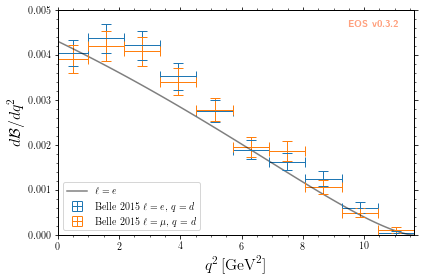

In [3]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.63], 'format': '${x:.0f}$' },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3], 'format': '${x:.3f}$' },
        'legend': { 'location': 'lower left' }
    },
    'contents': [
        {
            'label': r'$\ell=e$',
            'type': 'observable',
            'observable': 'B->Dlnu::dBR/dq2;l=e,q=d',
            'variable': 'q2',
            'color': 'black',
            'range': [0.02, 11.63],
        },
        {
            'label': r'Belle 2015 $\ell=e,\, q=d$',
            'type': 'constraint',
            'color': 'C0',
            'constraints': 'B^0->D^+e^-nu::BRs@Belle-2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': False
        },
        {
            'label': r'Belle 2015 $\ell=\mu,\,q=d$',
            'type': 'constraint',
            'color': 'C1',
            'constraints': 'B^0->D^+mu^-nu::BRs@Belle-2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': False
        },
    ]
}
eos.plot.Plotter(plot_args).plot()

## Creating the Posterior

In [4]:
analysis_args = {
    'global_options': { 'form-factors': 'BSZ2015', 'model': 'CKMScan' },
    'priors': [
        { 'parameter': 'CKM::abs(V_cb)',           'min':  38e-3, 'max':  45e-3 , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f+_0@BSZ2015', 'min':  0.0,   'max':  1.0   , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f+_1@BSZ2015', 'min': -4.0,   'max': -1.0   , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f+_2@BSZ2015', 'min': +4.0,   'max': +6.0   , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f0_1@BSZ2015', 'min': -1.0,   'max': +2.0   , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f0_2@BSZ2015', 'min': -2.0,   'max':  0.0   , 'type': 'uniform'}
    ],
    'likelihood': [
        'B->D::f_++f_0@HPQCD2015A',
        'B->D::f_++f_0@FNALMILC2015A',
        'B^0->D^+e^-nu::BRs@Belle-2015A',
        'B^0->D^+mu^-nu::BRs@Belle-2015A'
    ]
}
analysis = eos.Analysis(**analysis_args)
analysis.parameters['CKM::abs(V_cb)'].set(42.0e-3)

In [5]:
bfp = analysis.optimize()
display(bfp)
display(analysis.goodness_of_fit())

parameter,value
$|V_{cb}|$,0.0419
B->D::alpha^f+_0@BSZ2015,0.6671
B->D::alpha^f+_1@BSZ2015,-2.5314
B->D::alpha^f+_2@BSZ2015,4.8803
B->D::alpha^f0_1@BSZ2015,0.2660
B->D::alpha^f0_2@BSZ2015,-0.8412


In [6]:
e_q2values  = np.unique(np.concatenate((np.linspace(0.02,  1.00, 20), np.linspace(1.00, 11.60, 20))))
e_obs       = [eos.Observable.make(
                  'B->Dlnu::dBR/dq2', analysis.parameters, eos.Kinematics(q2=q2),
                  eos.Options(**{'form-factors': 'BSZ2015', 'l': 'e', 'q': 'd'}))
              for q2 in e_q2values]
parameter_samples, log_weights, e_samples  = analysis.sample(N=20000, stride=5, pre_N=1000, preruns=5, cov_scale=0.05, start_point=bfp.point, observables=e_obs)

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


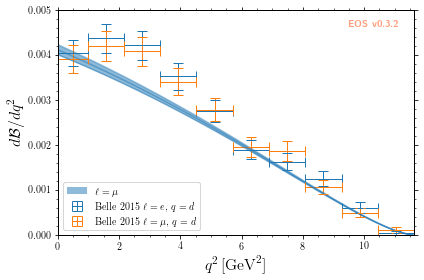

In [7]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.63], 'format': '${x:.0f}$' },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3], 'format': '${x:.3f}$' },
        'legend': { 'location': 'lower left' }
    },
    'contents': [
        {
          'label': r'$\ell=\mu$', 'type': 'uncertainty', 'range': [0.02, 11.60],
          'data': { 'samples': e_samples, 'xvalues': e_q2values }
        },
        {
            'label': r'Belle 2015 $\ell=e,\, q=d$',
            'type': 'constraint',
            'color': 'C0',
            'constraints': 'B^0->D^+e^-nu::BRs@Belle-2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': False
        },
        {
            'label': r'Belle 2015 $\ell=\mu,\,q=d$',
            'type': 'constraint',
            'color': 'C1',
            'constraints': 'B^0->D^+mu^-nu::BRs@Belle-2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': False
        },
    ]
}
eos.plot.Plotter(plot_args).plot()

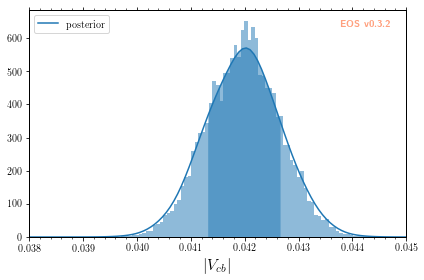

In [8]:
plot_args = {
    'plot': {
        'x': { 'label': r'$|V_{cb}|$', 'range': [38e-3, 45e-3], 'format': '${x:.3f}$' },
        'legend': { 'location': 'upper left' }
    },
    'contents': [
        {
            'type': 'histogram',
            'data': { 'samples': parameter_samples[:, 0], 'log_weights': log_weights }
        },
        {
            'type': 'kde', 'color': 'C0', 'label': 'posterior', 'bandwidth': 2,
            'range': [40e-3, 45e-3],
            'data': { 'samples': parameter_samples[:, 0], 'log_weights': log_weights }
        }
    ]
}
eos.plot.Plotter(plot_args).plot()

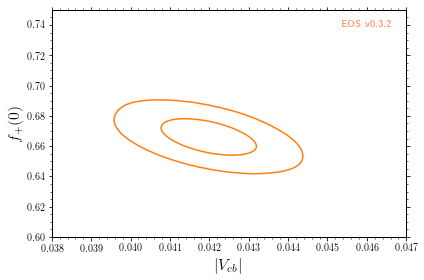

In [9]:
plot_args = {
    'plot': {
        'x': { 'label': r'$|V_{cb}|$', 'range': [38e-3, 47e-3], 'format': '${x:.3f}$' },
        'y': { 'label': r'$f_+(0)$', 'range': [0.6, 0.75], 'format': '${x:.2f}$' },
    },
    'contents': [
        {
            'type': 'kde2D', 'color': 'C1', 'label': 'posterior',
            'range': [40e-3, 45e-3], 'levels': [68, 99], 'bandwidth': 3,
            'data': { 'samples': parameter_samples[:, (0,1)], 'log_weights': log_weights }
        }
    ]
}
eos.plot.Plotter(plot_args).plot()

In [10]:
print('$|V_{{cb}}|$ = {mean:.4f} +/- {std:.4f}'.format(
    mean=np.average(parameter_samples[:,0], weights=np.exp(log_weights)),
    std=np.sqrt(np.var(parameter_samples[:, 0]))
))

$|V_{cb}|$ = 0.0420 +/- 0.0009
